# Debugging instability new configuration

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import glob
import netCDF4 as nc
import sys
import tqdm
sys.path.append('/home/users/birgal/')
from nemo_python.ics_obcs import vertical_edges

### Vertical interpolation of initial conditions debugging and fixing

In [ ]:
def interp_depth(source, source_edges, nemo_edges, n):
    # For a particular input nemo depth level, interpolate from source grid to nemo grid (conservatively nearest-neighbour)
    
    NEMO_top_edge = nemo_edges[0][n,:,:]; NEMO_bot_edge = nemo_edges[2][n,:,:];

    dataset = xr.Dataset({}) #.assign_coords(x=source.x, y=source.y)

    for var in source: # loop over the variables in the source dataset
        # find the source edges that fall within the depth ranges of the NEMO grid cells:
        # the weighting doesn't quite work right yet to make it conservative
        Var_total = np.zeros(NEMO_top_edge.shape); 
        for zs in range(0,source.z.size):
            src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

            # NEMO cells that fall fully within the SOSE cell:
            Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge <= src_bot_edge), \
                           source.isel(z=zs)*(NEMO_bot_edge - NEMO_top_edge), 0)
        
            # NEMO cells that have an overlap at the bottom:
            Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_top_edge >= src_top_edge), \
                           source.isel(z=zs)*(src_bot_edge - NEMO_top_edge), Var)
        
            # NEMO cells that have an overlap at the top:
            Var = xr.where((NEMO_top_edge < src_top_edge)*(NEMO_bot_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), \
                           source.isel(z=zs)*(NEMO_bot_edge - src_top_edge), Var)

            # SOSE cell smaller than NEMO cell and fully encapsulated:
            Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge)*(NEMO_top_edge < src_top_edge), \
                           source.isel(z=zs)*(src_bot_edge - src_top_edge), Var)
            
            # # Cell at the bottom of each column:
            Var = xr.where((NEMO_top_edge > np.max(src_bot_edge[~np.isnan(source)], axis=0)), \
                           np.nan, Var) # if the NEMO bottom grid cell is deeper than any SOSE, let fill_ocean deal with it later
            # NEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=383).SALT)]))
            # Var = xr.where((src_bot_edge > np.max(NEMO_bot_edge, axis=0))*(src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_top_edge), \
            #                source.isel(z=zs)*(src_bot_edge - NEMO_bot_edge), Var)

            Var_total += Var
        
        Var_total = Var_total/(NEMO_bot_edge - NEMO_top_edge)
        
        dataset[var] = (('y', 'x'), Var_total[var].values)

    return dataset

In [ ]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025-filledlakes.nc')

In [ ]:
hinterp_var = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-horizontal-interp.nc')

In [ ]:
source_coord = hinterp_var.assign(drF=(['z'], SOSE_coord.drF.values))
source_edges = vertical_edges(source_coord, mtype='SOSE')
nemo_edges   = vertical_edges(mesh, mtype='nemo')

model_ICs = []
for n in tqdm.tqdm(range(len(mesh.nav_lev.values))):
    data_interp = interp_depth(hinterp_var, source_edges, nemo_edges, n)        
    model_ICs.append(data_interp) # Add interpolated layers to dataset
    
source_interp = xr.concat(model_ICs, dim='z') 

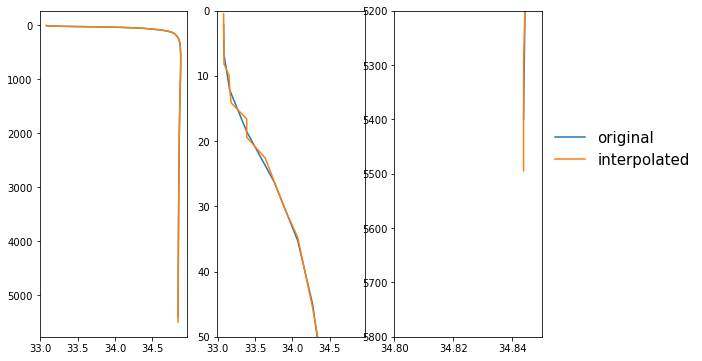

In [466]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(hinterp_var.SALT.sel(x=1050, y=383)  , SOSE_cent, label='original')
    axis.plot(source_interp.SALT.sel(x=1050, y=383), NEMO_cent, label='interpolated')

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

(5800.0, 5200.0)

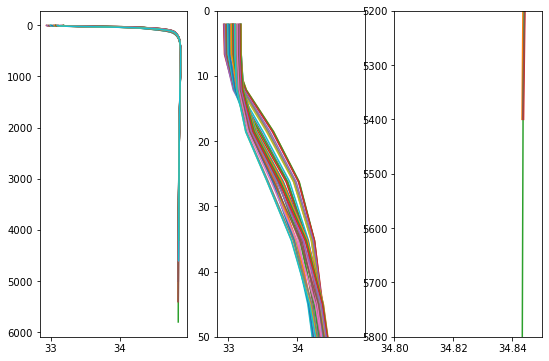

In [490]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    y_coord = np.arange(360,400)
    for yc in y_coord:
        axis.plot(hinterp_var.SALT.sel(x=1050, y=yc)  , SOSE_cent, label='original')

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

# ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

(5800.0, 5200.0)

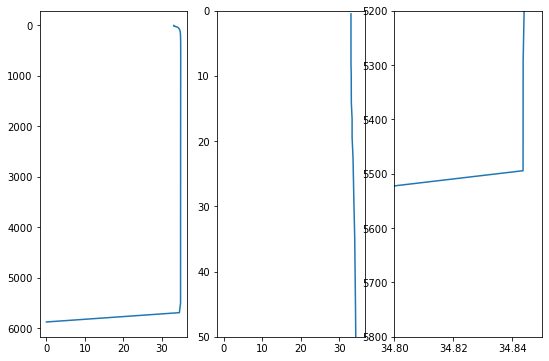

In [502]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(source_interp.SALT.sel(x=1050, y=382), NEMO_cent, label='interpolated')

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)

# ax[2].legend(fontsize=15, frameon=False, loc=(1.05, 0.5))
## temperature looks normal

In [519]:
# Find vertical cell edges
SOSE_coord      = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')
SOSE_coord['Z'] = abs(SOSE_coord['Z'])
SOSE_coord      = SOSE_coord.rename({'Z':'z'})
(z_top_edge, z_centres, z_bot_edge)          = vertical_edges(SOSE_coord, mtype='SOSE')
(nemo_top_edge, nemo_centres, nemo_bot_edge) = vertical_edges(mesh, mtype='nemo')

Let's focus the debugging/testing on cell x=1050, y=383:

In [563]:
SOSE_top = z_top_edge[:,0,0]        ; SOSE_bot = z_bot_edge[:,0,0]; SOSE_cent = z_centres[:,0,0];
NEMO_top = nemo_top_edge[:,382,1050]; NEMO_bot = nemo_bot_edge[:,382,1050]; NEMO_cent = nemo_centres[:,382,1050]

In [510]:
def plot_cond(ax, ind):
    ax[0]. plot([0.5], SOSE_cent[ind], '.m', markersize=20)
    
    NEMO_plot1 = np.ma.masked_where(~((NEMO_top >= SOSE_top[ind])*(NEMO_bot <= SOSE_bot[ind])), NEMO_cent)
    NEMO_plot2 = np.ma.masked_where(~((NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])), NEMO_cent)
    NEMO_plot3 = np.ma.masked_where(~((NEMO_top < SOSE_top[ind])*(NEMO_bot >= SOSE_top[ind])*(NEMO_bot < SOSE_bot[ind])), NEMO_cent)
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot1, '.r', markersize=25);
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot2, '.c', markersize=20);
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot3, '.b', markersize=10);

    return

In [487]:
# Mask depth levels that are deeper than the ocean depth in this location
z_bot_edge[z_bot_edge > SOSE_coord.Depth.values] = np.nan
# But, this won't quite work because I have the ocean depth levels from SOSE on tNEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=383).SALT)]))he SOSE grid, not on the horizontal NEMO grid
# Instead should I just assume the whole cell was filled? Not quite conservative then...

Text(0.5, 1.0, 'NEMO')

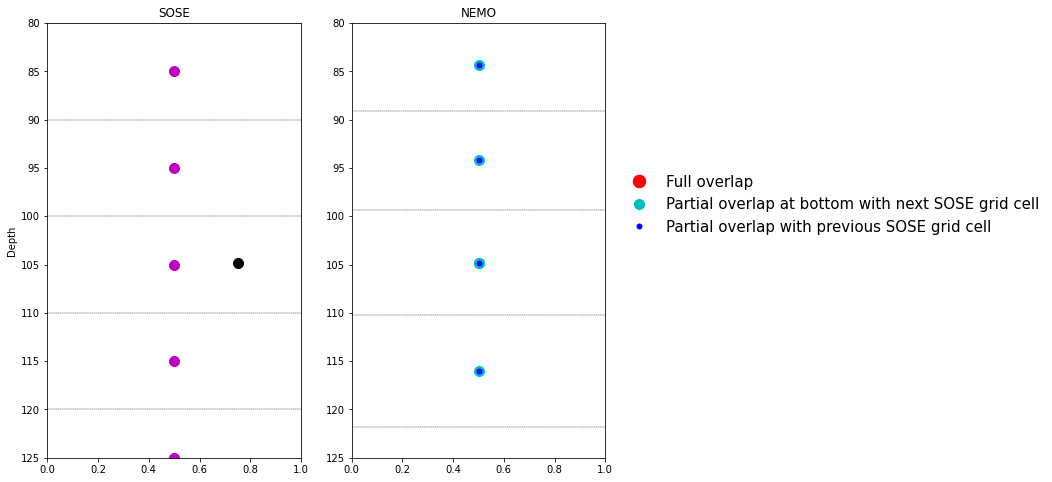

In [307]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_xlim(0, 1)
    axis.set_ylim(125, 80)
    
# SOSE:
[ax[0].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in SOSE_top]
ax[0].plot([0, 1], [SOSE_bot[-1], SOSE_bot[-1]], '--k', linewidth=0.4)
ax[0]. plot(0.5*np.ones(SOSE_cent.shape), SOSE_cent, '.k', markersize=10)
ax[0].set_title('SOSE')
ax[0].set_ylabel('Depth')

# NEMO:
[ax[1].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in NEMO_top]
ax[1]. plot(0.5*np.ones(NEMO_cent.shape), NEMO_cent, '.k', markersize=10)
ax[1].plot([0, 1], [NEMO_bot[-1], NEMO_bot[-1]], '--k', linewidth=0.4)

ax[1].plot([-0.5],[-0.5], '.r', markersize=25, label='Full overlap');
ax[1].plot([-0.5],[-0.5], '.c', markersize=20, label='Partial overlap at bottom with next SOSE grid cell');
ax[1].plot([-0.5],[-0.5], '.b', markersize=10, label='Partial overlap with previous SOSE grid cell');

for ind, cent in enumerate(SOSE_cent):
    plot_cond(ax, ind)

    NEMO_plot4 = np.ma.masked_where(~((SOSE_bot[ind] > np.max(NEMO_bot))*(SOSE_bot[ind] > NEMO_bot)*(SOSE_top[ind] < NEMO_top)), NEMO_cent)
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot4, '.k', markersize=10);

plot_cond(ax, 0)
# plot_cond(ax, 1)
ax[0].plot([0.75], [NEMO_cent[24]], '.k', markersize=20)

ax[1].legend(loc=(1.05, 0.5), frameon=False, fontsize=15)
ax[1].set_title('NEMO')

Text(0.5, 1.0, 'NEMO')

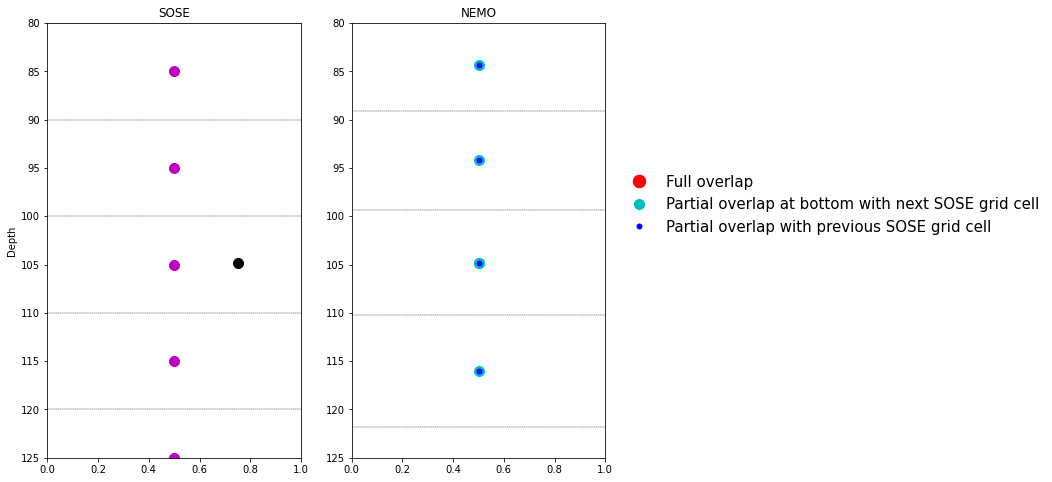

In [521]:
fig, ax = plt.subplots(1, 2, figsize=(10,8))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_xlim(0, 1)
    axis.set_ylim(125, 80)

# SOSE:
[ax[0].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in SOSE_top]
ax[0].plot([0, 1], [SOSE_bot[-1], SOSE_bot[-1]], '--k', linewidth=0.4)
ax[0]. plot(0.5*np.ones(SOSE_cent.shape), SOSE_cent, '.k', markersize=10)
ax[0].set_title('SOSE')
ax[0].set_ylabel('Depth')

# NEMO:
[ax[1].plot([0, 1], [layer, layer], '--k', linewidth=0.4) for layer in NEMO_top]
ax[1]. plot(0.5*np.ones(NEMO_cent.shape), NEMO_cent, '.k', markersize=10)
ax[1].plot([0, 1], [NEMO_bot[-1], NEMO_bot[-1]], '--k', linewidth=0.4)

ax[1].plot([-0.5],[-0.5], '.r', markersize=25, label='Full overlap');
ax[1].plot([-0.5],[-0.5], '.c', markersize=20, label='Partial overlap at bottom with next SOSE grid cell');
ax[1].plot([-0.5],[-0.5], '.b', markersize=10, label='Partial overlap with previous SOSE grid cell');

for ind, cent in enumerate(SOSE_cent):
    plot_cond(ax, ind)

    NEMO_plot4 = np.ma.masked_where(~((SOSE_bot[ind] > np.max(NEMO_bot))*(SOSE_bot[ind] > NEMO_bot)*(SOSE_top[ind] < NEMO_top)), NEMO_cent)
    ax[1].plot(0.5*np.ones(NEMO_cent.shape), NEMO_plot4, '.k', markersize=10);

ax[0].plot([0.75], [NEMO_cent[24]], '.k', markersize=20)

ax[1].legend(loc=(1.05, 0.5), frameon=False, fontsize=15)
ax[1].set_title('NEMO')

In [530]:
print(SOSE_bot[51])
print(np.max(NEMO_bot, axis=0))
print(np.max(NEMO_bot, axis=0), np.max(NEMO_top, axis=0))

6000.0
6411.525450991713
6411.525450991713 6003.539351044795


In [569]:
np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=382).SALT)])

6000.0

In [583]:
Var_total = np.zeros(NEMO_top.shape)

for ind in range(0,52):
    SOSE_salt = hinterp_var.isel(z=ind, x=1050, y=383).SALT.values
    
    NEMO_cond1 = (NEMO_top >= SOSE_top[ind])*(NEMO_bot <= SOSE_bot[ind])
    NEMO_cond2 = (NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])*(NEMO_top >= SOSE_top[ind])
    NEMO_cond3 = (NEMO_top < SOSE_top[ind] )*(NEMO_bot >= SOSE_top[ind])*(NEMO_bot < SOSE_bot[ind])
    NEMO_cond4 = (NEMO_top <= SOSE_bot[ind])*(NEMO_bot >= SOSE_bot[ind])*(NEMO_top < SOSE_top[ind])        
    # NEMO_cond5 = (SOSE_bot[ind] > np.max(NEMO_bot, axis=0))*(SOSE_bot[ind] > NEMO_bot)*(SOSE_top[ind] < NEMO_top)
    # if there is a nemo grid cell that is deeper than any SOSE grid cell, fill with NaN to be filled later by fill_ocean:
    NEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=383).SALT)]))
    
    Var = xr.where(NEMO_cond1, SOSE_salt*(NEMO_bot - NEMO_top)     , 0)
    Var = xr.where(NEMO_cond2, SOSE_salt*(SOSE_bot[ind] - NEMO_top), Var)
    Var = xr.where(NEMO_cond3, SOSE_salt*(NEMO_bot - SOSE_top[ind]), Var) 
    Var = xr.where(NEMO_cond4, SOSE_salt*(SOSE_bot[ind] - SOSE_top[ind]), Var) # full SOSE cell fits in NEMO cell that is bigger 
    Var = xr.where(NEMO_cond5, SOSE_salt*(SOSE_bot[ind] - NEMO_bot[ind]), Var)
    Var = xr.where(NEMO_cond6, np.nan, Var)
    NEMO_cond6 = (NEMO_top > np.max(SOSE_bot[~np.isnan(hinterp_var.isel(x=1050, y=383).SALT)]))
    Var_total += Var
    
print(Var_total/(NEMO_bot - NEMO_top))

[33.08093322 33.08093322 33.08093322 33.08181423 33.08506284 33.08506284
 33.08506284 33.15383239 33.16160161 33.18050383 33.38962513 33.38962513
 33.63650401 33.75682224 33.89182842 34.07181344 34.16610087 34.2717303
 34.36831649 34.42532155 34.48677103 34.54996332 34.60679206 34.65507963
 34.69768892 34.73372977 34.75939845 34.78001623 34.79517854 34.80580452
 34.81598271 34.82626755 34.83299015 34.83948353 34.84675755 34.85209898
 34.85606958 34.85962847 34.86283604 34.86601736 34.86651849 34.86982729
 34.86984152 34.87172258 34.87271796 34.87271796 34.87481966 34.87504285
 34.87504285 34.87654026 34.87676374 34.87676374 34.87764897 34.87780001
 34.87780001 34.87807572 34.87820706 34.87820706 34.87820706 34.87813977
 34.87804067 34.87804067 34.87804067 34.87804067 34.87804067 34.87758735
 34.87729919 34.87729919 34.87729919 34.87729919 34.87713053 34.87604379
 34.87604379 34.87604379 34.87604379 34.87569253 34.87438481 34.87438481
 34.87438481 34.8743206  34.87235608 34.87235608 34.

In [ ]:
34.84379278

In [584]:
print('Interpolated total', np.nansum((Var_total*mesh.e3t_0.isel(x=1050, y=383).values/(NEMO_bot - NEMO_top))))
print('Original total', np.nansum(hinterp_var.SALT.isel(x=1050,y=383)*SOSE_coord.drF))
# check if the difference is just because of my calculated edge locations

Interpolated total 194972.33988810692
Original total 195111.56460502028


In [379]:
print((Var_total*mesh.e3t_0.isel(x=1050, y=383)).isel(nav_lev=100).values)
print(Var_total[100], mesh.e3t_0.isel(x=1050, y=383).isel(nav_lev=100).values)

[548950.1277136]
4374.368751608471 [125.49242162]


In [368]:
print(np.nansum(mesh.e3t_0.isel(x=1050, y=383)))
print(np.nansum(SOSE_coord.drF))

5965.406081575895
6000.0


In [ ]:
# Loop over source cells:
for zs in range(0,source.z.size):
    src_top_edge = source_edges[0][zs,:,:]; src_bot_edge = source_edges[2][zs,:,:];

    # NEMO cells that fall fully within the SOSE cell:
    Var = xr.where((NEMO_top_edge >= src_top_edge)*(NEMO_bot_edge <= src_bot_edge), \
                   Var + source.isel(z=zs)*(NEMO_bot_edge - NEMO_top_edge), Var)

    # NEMO cells that have an overlap at the bottom:
    Var = xr.where((NEMO_top_edge <= src_bot_edge)*(NEMO_bot_edge >= src_bot_edge), \
                   Var + source.isel(z=zs)*(src_bot_edge - NEMO_top_edge), Var)

    # NEMO cells that have an overlap at the top:
    Var = xr.where((NEMO_top_edge <= src_top_edge)*(NEMO_bot_edge >= src_top_edge)*(NEMO_bot_edge < src_bot_edge), \
                   Var + source.isel(z=zs)*(NEMO_bot_edge - src_top_edge), Var)

    # Cell at the very bottom:
    if (zs==(source.z.size-1)):
        if src_bot_edge > np.max(NEMO_bot_edge): # source depth goes deeper than NEMO, so transfer variable to the above NEMO cell
            Var = xr.where((src_bot_edge > NEMO_bot_edge)*(src_top_edge < NEMO_top_edge),  Var + source.isel(z=zs)*(src_bot_edge - NEMO_bot_edge), Var)

    # find a test cell where this is the case:
    # elif src_bot_edge < np.max(NEMO_bot_edge): # source depth is shallower than NEMO, so transfer variable to the below NEMO cell
        #     Var = xr.where(,  Var + source.isel(z=zs)*(src_bot_edge - NEMO_bot_edge), Var)
    # --> then, add the left over bit to the bottom nemo grid ceel

XC: 2015, YC: 323

The original SOSE data at these profiles looks fine, so it is an issue with my vertical interpolation. I think that is because of the fill_bottom. Potentially I need to do fill bottom before the vertical interpolation instead of after

In [47]:
print(mesh.nav_lon.isel(x=1050,y=383).values)
print(mesh.nav_lat.isel(x=1050,y=383).values)
print('---')
print(mesh.nav_lon.isel(x=1051,y=383).values)
print(mesh.nav_lat.isel(x=1051,y=383).values)

-24.5
-59.896774
---
-24.25
-59.896774


(5800.0, 5200.0)

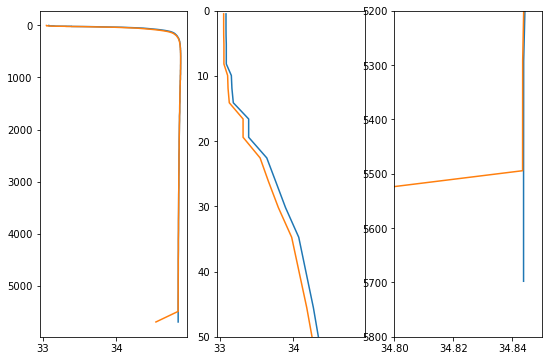

In [29]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(dss.SALT.sel(x=1050, y=383), mesh.nav_lev)
    axis.plot(dss.SALT.sel(x=1051, y=383), mesh.nav_lev)

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)
## temperature looks normal

(5800.0, 5200.0)

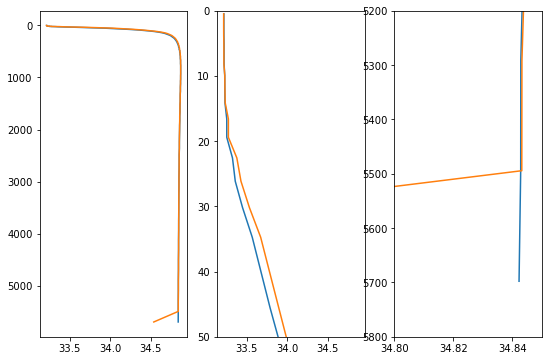

In [34]:
fig, ax = plt.subplots(1,3, figsize=(9,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(dss.SALT.sel(x=1050, y=411), mesh.nav_lev)
    axis.plot(dss.SALT.sel(x=1051, y=408), mesh.nav_lev)

ax[1].set_ylim(50,0)
ax[2].set_xlim(34.8,34.85)
ax[2].set_ylim(5800,5200)
## temperature looks normal

salinity = 34.541 at depth level > 110 (fresher water underneath saltier is causing the instability), initial condition profiles also look sort of steppy which doesn't quite seem right, probably because of my vertical interpolation method. Reconsider?
--> consider using https://xgcm.readthedocs.io/en/latest/transform.html instead for vertical interpolation
or especially for boundary conditions, could consider interpolating with cf along slices of x, z 

First, test issue with initial conditions at the bottom and figure out whether it is because of:
- copying the bottom grid cell over in step just after vertical interpolation
- ocean_fill
- or the last step where I fill any remaining empty cells (the cells that are filled are 318, 1350; 318, 1351)
  
by looking at the vertical-interp output netcdf and viewing the profiles at the problem grid location

Then, fix the vertical interpolation method to be properly conservative.

In [3]:
def plot_bottom(dss, depths, title=''):

    fig, ax = plt.subplots(1,2, figsize=(6,6))
    for axis in ax.ravel():
        axis.invert_yaxis()
        axis.plot(dss.SALT.sel(x=1050, y=383), depths)
        axis.plot(dss.SALT.sel(x=1051, y=383), depths)
    
    ax[1].set_xlim(34.5,35.2)
    ax[1].set_ylim(5800,5200)
    fig.suptitle(f'{title}')

    return fig, ax

In [4]:
mesh = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025-filledlakes.nc')

In [6]:
# no ocean fill, no copying over of grid cell:
ds1 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-test-vertical-interp.nc')
# with ocean fill, no copying over of grid cell:
ds2 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test2-initial-conditions.nc')
# with ocean fill, fill_val=34.85, no copying over of grid cell:
# ds3 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test3-initial-conditions.nc')
# with ocean fill and copying over of grid cell:
ds4 = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-test4-initial-conditions.nc')

In [ ]:
fig, ax = plot_bottom(ds1, mesh.nav_lev, title='No ocean fill, no bottom copy')

In [ ]:
fig, ax = plot_bottom(ds2, mesh.nav_lev, title='With ocean fill, no bottom copy, fill value is mean')

In [ ]:
fig, ax = plot_bottom(ds3, mesh.nav_lev, title='With ocean fill, no bottom copy, fill value is 34.85')
ax[1].set_xlim(34.5,34.65)

(<Figure size 432x432 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

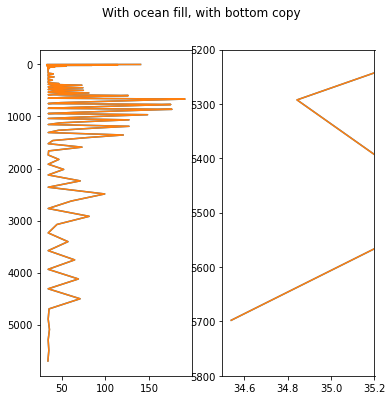

In [8]:
plot_bottom(ds4, mesh.nav_lev, title='With ocean fill, with bottom copy')

Next, improve the vertical interpolation

In [57]:
# Try vertical interpolation with xgcm: https://xgcm.readthedocs.io/en/latest/transform.html#Conservative-transformation

# Find vertical cell edges
SOSE_coord      = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/B-SOSE/climatology/SALT_climatology_m01.nc')
SOSE_coord['Z'] = abs(SOSE_coord['Z'])
SOSE_coord      = SOSE_coord.rename({'Z':'z'})
(z_top_edge, z_centres, z_bot_edge) = vertical_edges(SOSE_coord, mtype='SOSE')

# step (1) --- make variable into an extensive (volume-weighted) property:
dst = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-olddomain-horizontal-interp.nc')
T2d = dst.copy()
T2d['SALT'] = dst.SALT*SOSE_coord.drF
T2d = T2d.assign_coords({'zc': np.insert(z_bot_edge[:,0,0], 0, 0., axis=0)})

# step (2) --- recreate the grid object with a stagg~ered `center`/`outer` coordinate layout
grid = Grid(T2d, coords={'Z':{'center':'z', 'outer':'zc'}}, periodic=False)
# # grid_top_edge

# step(3) --- interpolate salt to outer coordinate of grid object
T2d['salt_outer'] = grid.interp(T2d.SALT, 'Z', boundary='fill')

# step (4) --- transform the data using the conservative method.
nemo_depths_target = mesh.nav_lev.values

# and transform
transformed_cons = grid.transform(T2d.SALT, 'Z', nemo_depths_target, method='conservative')#, target_data=T2d.salt_outer)

/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/users/birgal/.conda/envs/jaspy3.10/lib/python3.10/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [5]:
# new_ds = (transformed_cons).to_dataset()
new_ds = (transformed_cons/ np.diff(nemo_depths_target)).to_dataset()

In [6]:
print(np.nansum(transformed_cons.sel(x=1050, y=383)))
print(np.nansum(T2d['SALT'].sel(x=1050, y=383)))

191418.39623310522
195111.56460502028


(200.0, 0.0)

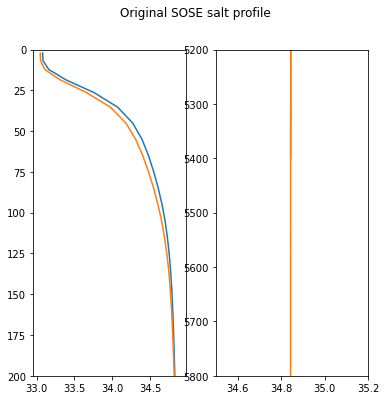

In [57]:
fig, ax = plot_bottom(dst, z_centres[:,0,0], title='Original SOSE salt profile')
ax[0].set_ylim(200,0)

(200.0, 0.0)

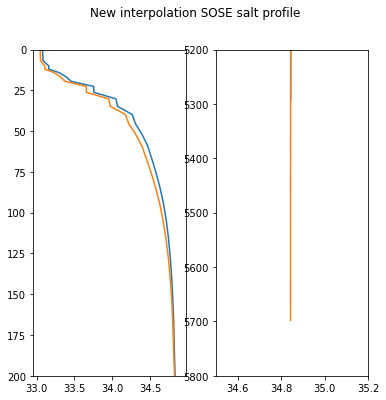

In [56]:
fig, ax = plot_bottom(new_ds, nemo_depths_target[:-1], title='New interpolation SOSE salt profile')
ax[0].set_ylim(200,0)

Try a simple scipy vertical 1d interpolation instead:

In [7]:
from scipy.interpolate import interp1d

In [8]:
f = interp1d(SOSE_coord.z, dst.SALT.values, axis=0, fill_value='extrapolate')
ynew = f(mesh.nav_lev.values)  
# plt.plot(x, y, 'o', xnew, ynew, '-')
# plt.show()

In [14]:
print(np.nansum(ynew[:,383,1050]*mesh.e3t_0.isel(time_counter=0, y=383, x=1050).values))
print(np.nansum(T2d['SALT'].sel(x=1050, y=383)))

187908.55550413116
195111.56460502028


(5800.0, 5200.0)

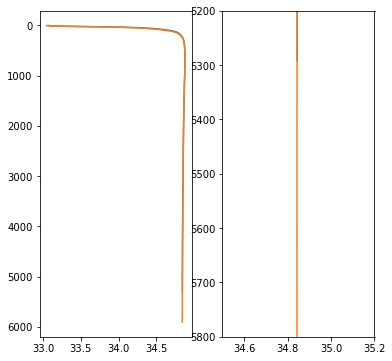

In [16]:
fig, ax = plt.subplots(1,2, figsize=(6,6))
for axis in ax.ravel():
    axis.invert_yaxis()
    axis.plot(ynew[:,383,1050], mesh.nav_lev.values)
    axis.plot(ynew[:,383,1051], mesh.nav_lev.values)
        
ax[1].set_xlim(34.5,35.2)
ax[1].set_ylim(5800,5200)

### New domain 1ts based debugging

Time step size: 100 s

Error region:
```
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 60 |ssh| max   4.662     at i j    340 395     MPI rank 568
 kt 60 |U|   max   10.06     at i j k 1050 383 120 MPI rank 596
 kt 60 Sal   min   25.86     at i j k 1052 406 120 MPI rank 655
 kt 60 Sal   max   35.36     at i j k  362 220  33 MPI rank 146
```

In [ ]:
folder_1ts = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability-1ts/'

In [4]:
folder_1ts = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability-1ts/'
dfT = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_T_19790101010640-19790101013959.nc')
# dfU = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_U_19790101010640-19790101013959.nc')
# dfV = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_V_19790101010640-19790101013959.nc')
# dfW = xr.open_dataset(f'{folder_1ts}eANT025.L121_1ts_19790101_19790128_grid_W_19790101010640-19790101013959.nc')

In [5]:
dfT.isel(time_counter=slice())

<xarray.Dataset>
Dimensions:                (y_grid_T: 453, x_grid_T: 1440, nvertex_grid_T: 4,
                            deptht: 121, axis_nbounds: 2, time_counter: 20,
                            y_grid_T_inner: 453, x_grid_T_inner: 1440)
Coordinates:
    nav_lat_grid_T         (y_grid_T, x_grid_T) float32 ...
    nav_lon_grid_T         (y_grid_T, x_grid_T) float32 ...
  * deptht                 (deptht) float32 0.4921 1.526 ... 5.698e+03 5.902e+03
    time_centered          (time_counter) datetime64[ns] ...
  * time_counter           (time_counter) datetime64[ns] 1979-01-01T01:07:30 ...
Dimensions without coordinates: y_grid_T, x_grid_T, nvertex_grid_T,
                                axis_nbounds, y_grid_T_inner, x_grid_T_inner
Data variables: (12/15)
    bounds_nav_lon_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    bounds_nav_lat_grid_T  (y_grid_T, x_grid_T, nvertex_grid_T) float32 ...
    area_grid_T            (y_grid_T, x_grid_T) float32 ...
    deptht_bounds          (deptht, axis_nbounds) float32 ...
    time_centered_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds    (time_counter, axis_nbounds) datetime64[ns] ...
    ...                     ...
    zos                    (time_counter, y_grid_T, x_grid_T) float32 ...
    mldr10_1               (time_counter, y_grid_T, x_grid_T) float32 ...
    sbt                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sbs                    (time_counter, y_grid_T_inner, x_grid_T_inner) float32 ...
    sosst                  (time_counter, y_grid_T, x_grid_T) float32 ...
    sosss                  (time_counter, y_grid_T, x_grid_T) float32 ...
Attributes:
    name:         eANT025.L121_1ts_19790101_19790128_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2024-Jan-17 17:16:27 GMT
    uuid:         46be6245-0a66-4b7b-86de-eaf9e9d5cead

In [ ]:
dfT.isel(time_counter=slice())

## Old domain

In [130]:
# old domain, new conditions:
dst  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-THETA-initial-conditions.nc')
dss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SALT-initial-conditions.nc')
dsic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceArea-initial-conditions.nc')
dsit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHeff-initial-conditions.nc')
dsnt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-old-domain-SeaIceHsnow-initial-conditions.nc')

In [ ]:
# Create new initial conditions for the old configuration
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
# dstn = dsto.drop_vars('sossh').copy()
dst_new = dst.THETA.values[np.newaxis, ...]
dss_new = dss.SALT.values[np.newaxis, ...]
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','y','x'), dst_new
dstn['vosaline'] = ('time_counter','deptht','y','x'), dss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS_new.nc', unlimited_dims='time_counter')

Starting old config from rest, with istate_TS with(out) sossh variable, it crashes at time step 7:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 7 |ssh| max   3.278     at i j   1054 393     MPI rank 619
 kt 7 |U|   max   27.10     at i j k 1053 393   1 MPI rank 619
 kt 7 Sal   min  0.1000     at i j k 1054 398   1 MPI rank 691
 kt 7 Sal   max   42.18     at i j k 1054 404 119 MPI rank 691
```
When I changed the time step from 1350s to 360s, it crashes at time step 21. Similar for 720s at time step 11, 100s at time step 75.
With boundary conditions kept equal to the initial conditions doesn't change anything. Anyways, for now, let's focus on getting the new initial conditions to even go past one time step.

New initial TS conditions on old config (boundary conditions held equal to initial conditions), with NaNs replaced by 0 and 10, and zero salinity values replaced by 10, ts=1350s, crashes at time step 8. Same when reading in new ice conditions as well:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 8 |ssh| max   1.868     at i j    882 318     MPI rank 395
 kt 8 |U|   max   92.60     at i j k 1053 393   1 MPI rank 619
 kt 8 Sal   min  0.1000     at i j k 1054 393   1 found in   2 MPI tasks, spread out among ranks 619 to 691
 kt 8 Sal   max   40.09     at i j k 1049 408 119 MPI rank 691

```
Next, test new initial TS conditions with new T, S boundary conditions (with zeros filled and reshaped like below as well) on old config (tricky because the boundary dimensions are different).

In [95]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
dstn = dsto.drop_vars(['sivolu','snvolu']).copy()
dsic_new = dsic.SIarea.values[np.newaxis, ...]
dsit_new = dsit.SIheff.values[np.newaxis, ...]
dsnt_new = dsnt.SIhsnow.values[np.newaxis, ...]
dsic_new[np.isnan(dsic_new)] = 0
dsit_new[np.isnan(dsit_new)] = 0
dsnt_new[np.isnan(dsnt_new)] = 0
dsic_new[dsic_new < 0.001] = 0
dsit_new[dsit_new < 0.001] = 0
dsnt_new[dsnt_new < 0.001] = 0
dstn['siconc'] = ('time_counter','y','x'), dsic_new
dstn['sithic'] = ('time_counter','y','x'), dsit_new
dstn['snthic'] = ('time_counter','y','x'), dsnt_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice_new.nc')

In [125]:
# Combine boundary condition files:
for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/THETA-*')):
    if i==0:
        dst_concat = xr.open_dataset(file)
    else:
        dst_concat = xr.concat([dst_concat, xr.open_dataset(file)], 'time_counter')

for i, file in enumerate(glob.glob('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/SALT-*')):
    if i==0:
        dss_concat = xr.open_dataset(file)
    else:
        dss_concat = xr.concat([dss_concat, xr.open_dataset(file)], 'time_counter')

In [ ]:
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_tra_y1979.nc').isel(time_counter=slice(0,72,6))
dstn = dsto.drop_vars('sossh').copy()
dst_new = dst_concat.THETA.values
dss_new = dss_concat.SALT.values
dst_new[np.isnan(dst_new)] = 0
dss_new[np.isnan(dss_new)] = 10
dss_new[dss_new==0] = 10
dstn['votemper'] = ('time_counter','deptht','yb','xbT'), dst_new
dstn['vosaline'] = ('time_counter','deptht','yb','xbT'), dss_new
dstn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/boundary-conditions/bdyT_new_tra_y1979.nc')

### New domain:

In [ ]:
folder = '/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/output/instability/'

ds = xr.open_dataset(f'{folder}output.abort_0000.nc', drop_variables=['x', 'y'])

In [ ]:
# new domain, new conditions:
st  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-THETA-initial-conditions.nc')
ss  = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc')
sic = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceArea-initial-conditions.nc')
sit = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHeff-initial-conditions.nc')
snt = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SeaIceHsnow-initial-conditions.nc')

In [149]:
# fill NaN and small values in new initial conditions with zeros or 10
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_TS.nc')
stn    = st.drop_vars(['THETA'])
st_new = st.THETA.values[np.newaxis, ...]
ss_new = ss.SALT.values[np.newaxis, ...]
st_new[np.isnan(st_new)] = 0
ss_new[np.isnan(ss_new)] = 10
ss_new[ss_new==0] = 10
stn['votemper'] = ('time_counter','deptht','y','x'), st_new
stn['vosaline'] = ('time_counter','deptht','y','x'), ss_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_TS_new.nc', unlimited_dims='time_counter')

In [147]:
# fill NaN and small values in new initial conditions with zeros
dsto = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/istate_sea_ice.nc')
stn  = st.drop_vars(['THETA'])
sic_new = sic.SIarea.values[np.newaxis, ...]
sit_new = sit.SIheff.values[np.newaxis, ...]
snt_new = snt.SIhsnow.values[np.newaxis, ...]
sic_new[np.isnan(sic_new)] = 0
sit_new[np.isnan(sit_new)] = 0
snt_new[np.isnan(snt_new)] = 0
sic_new[sic_new < 0.001] = 0
sit_new[sit_new < 0.001] = 0
snt_new[snt_new < 0.001] = 0
stn['siconc'] = ('time_counter','y','x'), sic_new
stn['sithic'] = ('time_counter','y','x'), sit_new
stn['snthic'] = ('time_counter','y','x'), snt_new
stn = stn.assign_coords({'time_counter':dsto.time_counter})
stn.to_netcdf('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE_istate_sea_ice_new.nc', unlimited_dims='time_counter')

new domain, with new filled initial conditions from above, boundaries kept constant, no icebergs or runoff, crashes after 6 time steps with dt=1350s:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 6 |ssh| max   2.187     at i j   1050 382     MPI rank 596
 kt 6 |U|   max   47.77     at i j k  339 395   1 MPI rank 568
 kt 6 Sal   min  0.1000     at i j k 1050 382   1 found in   2 MPI tasks, spread out among ranks 568 to 596
 kt 6 Sal   max   53.38     at i j k  340 396 120 MPI rank 568

        ===> output of last computed fields in output.abort* files 
```
--> it seems that it was important to fill the NaNs with normal values, and possibly to include the time_counter dimension as well.

Next: same setup as previous, testing timestep:
- dt=1350s, crashes at: ts=6 ==> 8100s
- dt=720s , crashes at: ts=9 ==> 6480s
- dt=100s , crashes at: ts=60 ==> 6000s

dt=100:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests

 kt 60 |ssh| max   4.662     at i j    340 395     MPI rank 568
 kt 60 |U|   max   10.06     at i j k 1050 383 120 MPI rank 596
 kt 60 Sal   min   25.86     at i j k 1052 406 120 MPI rank 655
 kt 60 Sal   max   35.36     at i j k  362 220  33 MPI rank 146
```

dt=10:
```
  ===>>> : E R R O R

          ===========

   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
           
 kt 583 |ssh| max   5.821     at i j    340 395     MPI rank 568
 kt 583 |U|   max   10.14     at i j k  339 395  41 MPI rank 568        
 kt 583 Sal   min   25.83     at i j k 1052 406 120 MPI rank 655
 kt 583 Sal   max   35.36     at i j k  362 220  34 MPI rank 146

        ===> output of last computed fields in output.abort* files

```

I was able to start without key_qco by running with ln_wd_il and nn_wdit commented out in namwad namelist section

### other older stuff

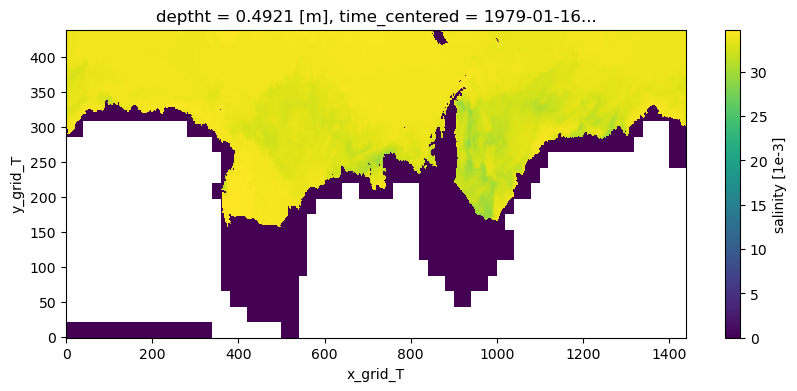

In [9]:
ds1.so.isel(time_counter=0, deptht=0).plot(figsize=(10,4))

In [100]:
file_list = glob.glob(f'{folder}output.abort_????.nc')
# file_list = glob.glob(f'{folder}output.init_????.nc')

Error:

```                     
   stp_ctl: |ssh| > 20 m  or  |U| > 10 m/s  or  S <= 0  or  S >= 100  or  NaN encounter in the tests
                     
 kt 1 |ssh| max -1.7977+308 at i j    401 134     found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 |U|   max -1.7977+308 at i j k  424 146  22 found in   6 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   min  1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
 kt 1 Sal   max -1.7977+308 at i j k  424 146  22 found in   4 MPI tasks, spread out among ranks   7 to 135
```

Tried halving the timestep and printing out the initial state. Other options:
- Use old bathymetry, starting from rest with all old conditions, icebergs off
- Use old bathymetry, starting from rest with new initial conditions for sea ice and T, S
- Use new bathymetry, starting from rest with all new conditions, but filling all zero/nan values in the forcing files with constants instead

In [ ]:
list_first = []
list_last  = [] 
for file in file_list:
    ds = xr.open_dataset(f'{file}', drop_variables=['x', 'y'])
    list_first.append(ds.attrs['DOMAIN_position_first'])
    list_last.append(ds.attrs['DOMAIN_position_last'])
    ds.close()

In [74]:
for i, ind in enumerate(list_first):
    if ind[0] <= 424 and (list_last[i][0] >= 424) and ind[1] <= 146 and (list_last[i][1] >= 146):
        print(i)

72


In [64]:
for i, ind in enumerate(list_first):
    if ind[0] <= 350 and (list_last[i][0] >= 350) and ind[1] <= 350 and (list_last[i][1] >= 350):
        print(i)

452


In [98]:
def xr_open_with_rename(fn, renames):
    ds    = xr.open_dataset(fn, drop_variables=renames.keys())    
    ds_nc = nc.Dataset(fn)
    for v in renames:
        nc_var=ds_nc[v]
        ds[renames[v]]= nc_var.dimensions, nc_var[...]
    ds_nc.close()
    ds = ds.set_coords(renames.values())    
    ds.to_netcdf(f"{folder}r-{fn.split('/')[-1]}")
    return ds

In [102]:
ds_issue = xr_open_with_rename(f'{file_list[72]}', dict(x="x_coord",y="y_coord"))

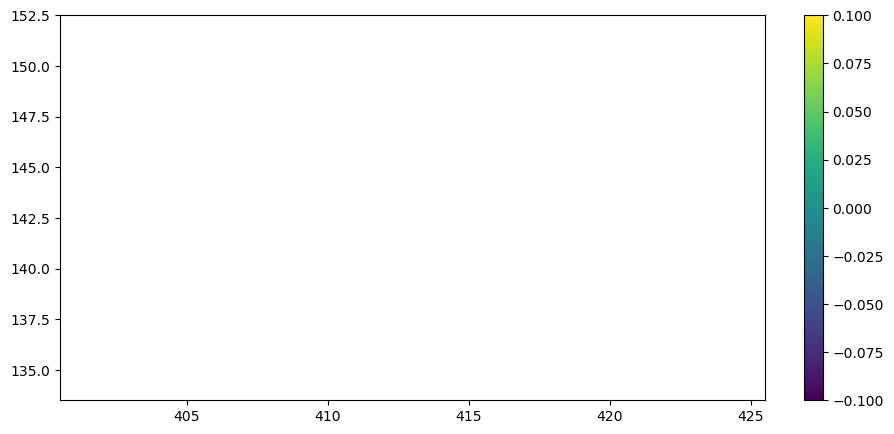

In [105]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=21).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

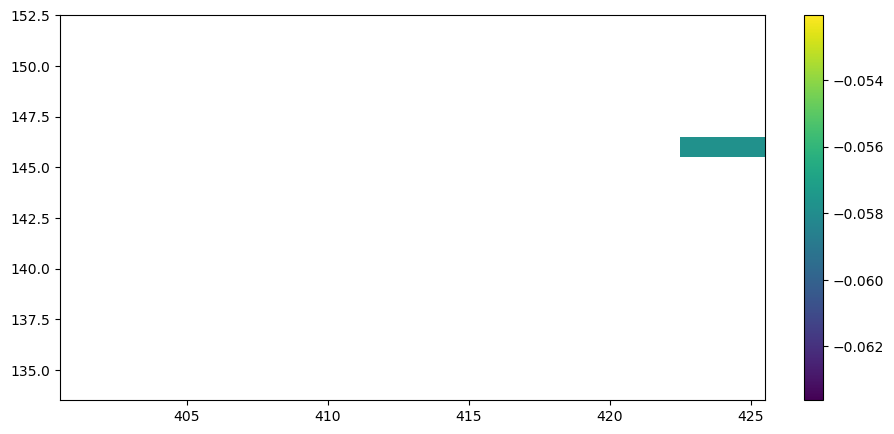

In [93]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.votemper.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)

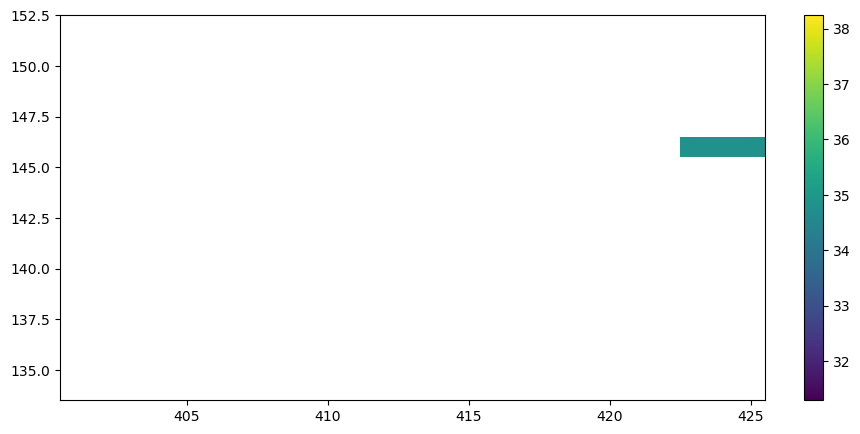

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
x, y = np.meshgrid(ds_issue.x + ds_issue.attrs['DOMAIN_position_first'][0], 
                   ds_issue.y + ds_issue.attrs['DOMAIN_position_first'][1])
cm1 = ax.pcolormesh(x, y, ds_issue.vosaline.isel(time_counter=0, nav_lev=22).values)
CB1 = fig.colorbar(cm1, ax=ax, fraction=0.04)
# ds_issue.votemper.isel(time_counter=0, nav_lev=22).plot(x=ds_issue.x_coord, y=ds_issue.y_coord)